# KNN classifier for Iris dataset

Importing libraries to be used

In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import preprocessing, manifold, decomposition
from random import shuffle

Reading dataset and visualizing first five rows

In [2]:
df = pd.read_csv('../datasets/iris.csv')
df.head()

,Largo_sep,Ancho_sep,Largo_pet,Ancho_pet,Tipo_Flor
0,6.0,2.9,4.5,1.5,Iris-versicolor
1,6.8,3.0,5.5,2.1,Iris-virginica
2,6.3,2.5,4.9,1.5,Iris-versicolor
3,5.5,4.2,1.4,0.2,Iris-setosa
4,6.2,3.4,5.4,2.3,Iris-virginica


Showing a general description of the dataset

In [3]:
df.describe()

,Largo_sep,Ancho_sep,Largo_pet,Ancho_pet
count,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.054000,3.758667,1.198667
std,0.828066,0.433594,1.764420,0.763161
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


Looking for null values within the dataset

In [4]:
df.isnull().values.any()

False

Spliting Features(X) and labels(y)

In [5]:
X = df.drop(columns="Tipo_Flor")
y = df[["Tipo_Flor"]]
X.head()

,Largo_sep,Ancho_sep,Largo_pet,Ancho_pet
0,6.0,2.9,4.5,1.5
1,6.8,3.0,5.5,2.1
2,6.3,2.5,4.9,1.5
3,5.5,4.2,1.4,0.2
4,6.2,3.4,5.4,2.3


Encoding our classes from categorical values to numerical

In [6]:
le = preprocessing.LabelEncoder()
y["Tipo_Flor"] = le.fit_transform(df['Tipo_Flor'])
y.head()

/Users/dcordova/.virtualenvs/stcd/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Tipo_Flor
0,1
1,2
2,1
3,0
4,2


# Dimentionality reduction

To have a clear and easier to visualize representation of our data we applied some
dimentionality reduction, to go from data y 4d to 2d.

# Isomap

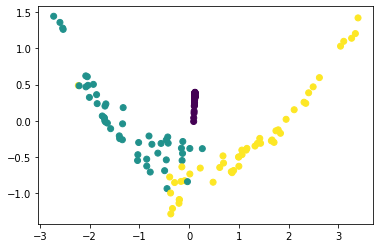

In [7]:
isomap = manifold.Isomap()
X_isomap = isomap.fit_transform(X)
plt.scatter(X_isomap[:, 0], X_isomap[:,1], c=y.Tipo_Flor)
plt.show()

# t-sne

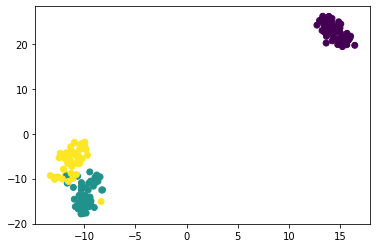

In [8]:
tsne = manifold.TSNE()
X_tsne = tsne.fit_transform(X)
plt.scatter(X_tsne[:, 0], X_tsne[:,1], c=y.Tipo_Flor)
plt.show()

## PCA

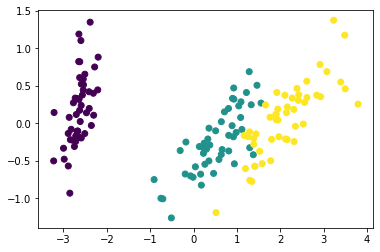

In [9]:
pca = decomposition.PCA()
X_pca = pca.fit_transform(X)
plt.scatter(X_pca[:,0],X_pca[:,1], c=y.Tipo_Flor)
plt.show()

After vizaluizing with different techniques, we opted to stay with the t-SNE, due to the better clustering it generated.

## Train / Test split

We divide the data in two datasets to cross validate the accuracy of our algorithm

In [10]:
indexes = list(X.index)
n_samples = len(indexes)
shuffle(indexes)
indexes = np.array(indexes)
dataset = X_tsne[indexes]
dataset_labels = y.iloc[indexes]
split = len(dataset)//5
x_train = dataset[:n_samples-split]
x_test = dataset[n_samples-split:]
y_train = dataset_labels[:n_samples-split]
y_test = dataset_labels[n_samples-split:]


## KNN

In [11]:
def min_distance(x, y):
    '''
    Function that returns the minimum euclidean distance 
    between two n-dimentional coordinates.
    '''
    return math.sqrt(sum([(a - b) ** 2 for a, b in zip(x, y)]))

def get_distances(p, X):
    '''
    Function that receives a point and a 2d array of points
    and calculates the distance between the given point and 
    all the points on the array
    '''
    distances = np.zeros(X.shape[0])
    for i in range(X.shape[0]):
        distances[i] = min_distance(p, X[i])
    df_dists = pd.DataFrame(data=distances, index=range(X.shape[0]), columns=['dist'])
    df_dists.head()
    return df_dists

def get_nn(dists, n):
    '''
    Function to get the n nearest neighbors from a dataframe
    with distances
    '''
    return dists.sort_values(by=['dist'], axis=0)[:n]

def knn(points, X, y, n):
    '''
    Our implementation of the KNN algorithm for a list of points
    '''
    preds = []
    for p in points:
        df_dist = get_distances(p,X_tsne)
        nn = get_nn(df_dist, 10)
        nn_labels = y.iloc[nn.index]
        pred = nn_labels.value_counts().index[0][0]
        preds.append(pred)
    return pd.DataFrame(data=preds, columns=['Tipo_Flor'])

## Testing our algorithm on test split

In [12]:
preds = knn(x_test, x_train, y, 7)

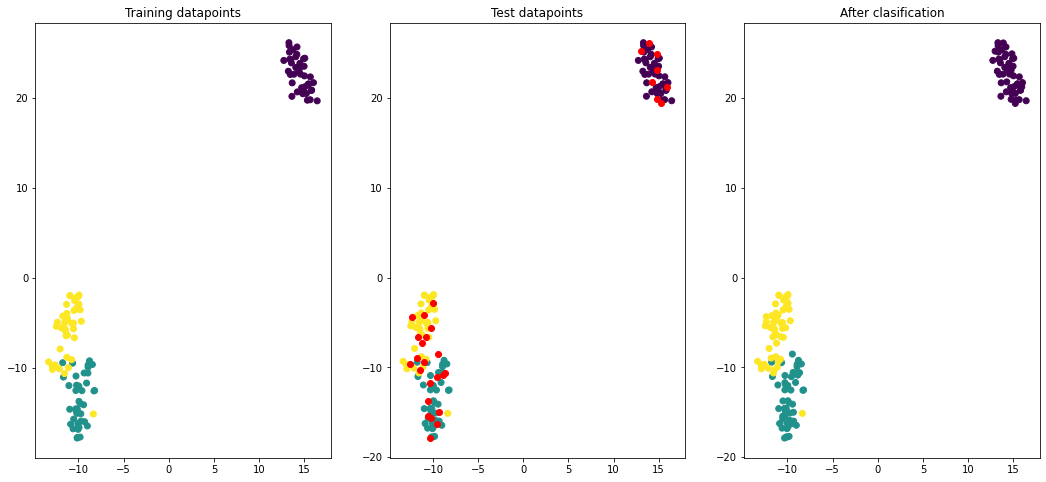

In [13]:
fig, ax = plt.subplots(1, 3, figsize=(18, 8))

ax[0].scatter(x_train[:, 0], x_train[:,1], c=y_train.Tipo_Flor)
ax[0].set_title("Training datapoints")
ax[1].scatter(x_train[:, 0], x_train[:,1], c=y_train.Tipo_Flor)
ax[1].scatter(x_test[:, 0], x_test[:,1], c='r')
ax[1].set_title("Test datapoints")
ax[2].scatter(x_train[:, 0], x_train[:,1], c=y_train.Tipo_Flor)
ax[2].scatter(x_test[:, 0], x_test[:,1], c=preds.Tipo_Flor)
ax[2].set_title("After clasification")

plt.show()

In [14]:
acc = preds.Tipo_Flor.to_numpy() == y_test.Tipo_Flor.to_numpy()
acc = sum(acc)/len(acc)
print(f'The accuracy of our model on the test split was {acc*100:.2f}%')

The accuracy of our model on the test split was 100.00%
